# 1.) Import Libraries

In [1]:
# Work with Data - the main Python libraries
import numpy as np
import pandas as pd

# For import data from API
import requests

# Visualization
import matplotlib.pyplot as plt

# Modeling and Prediction
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.simplefilter('ignore')

In [2]:
prediction_period = 180  # Period for prediction, days

# 2.) Download the data

In [3]:
# Download data via API from the Portal of RNBO of Ukraine: https://api-covid19.rnbo.gov.ua/
# https://api-covid19.rnbo.gov.ua/charts/main-data?mode=ukraine
code_region = 4914  # "Zhytomyrskа oblast"
print(f'Download daily data from the Portal of RNBO of Ukraine')
myfile = requests.get(f'https://api-covid19.rnbo.gov.ua/charts/main-data?mode=ukraine&country={code_region}')
open('data', 'wb').write(myfile.content)
df_data = pd.read_json('data')
df_data

Download daily data from the Portal of RNBO of Ukraine


,dates,confirmed,deaths,recovered,existing
0,2020-01-22,0,0,0,0
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,0,0,0,0
...,...,...,...,...,...
515,2021-06-20,88283,1779,85896,608
516,2021-06-21,88292,1781,85906,605
517,2021-06-22,88295,1782,85926,587
518,2021-06-23,88312,1784,85976,552


In [4]:
# Display the last 10 rows of the dataframe "df_data"
df_data.tail(10)

,dates,confirmed,deaths,recovered,existing
510,2021-06-15,88176,1774,85587,815
511,2021-06-16,88188,1774,85665,749
512,2021-06-17,88223,1774,85760,689
513,2021-06-18,88250,1778,85848,624
514,2021-06-19,88270,1779,85873,618
515,2021-06-20,88283,1779,85896,608
516,2021-06-21,88292,1781,85906,605
517,2021-06-22,88295,1782,85926,587
518,2021-06-23,88312,1784,85976,552
519,2021-06-24,88329,1784,86084,461


In [5]:
# Calculation daily data for number of confirmed cases
df_data['n_confirmed'] = df_data['confirmed'].diff()
#df_data['n_confirmed'] = df_data['confirmed']

In [6]:
# Filtering the missing data
data = df_data[['dates','n_confirmed']].dropna().reset_index(drop=True)
data['n_confirmed'] = data['n_confirmed'].astype('int')
data.tail(4)

,dates,n_confirmed
515,2021-06-21,9
516,2021-06-22,3
517,2021-06-23,17
518,2021-06-24,17


In [7]:
# Delete the last zero value
data = data[:-1]
data.tail(3)

,dates,n_confirmed
515,2021-06-21,9
516,2021-06-22,3
517,2021-06-23,17


<AxesSubplot:>

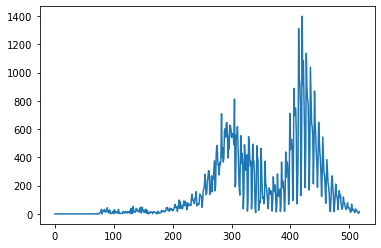

In [8]:
# Build the plot
data['n_confirmed'].plot()

In [9]:
# Prepairing data for modeling with Prophet
data.columns = ['ds', 'y']
data.tail()

,ds,y
513,2021-06-19,20
514,2021-06-20,13
515,2021-06-21,9
516,2021-06-22,3
517,2021-06-23,17


In [10]:
# Removing zero values
data = data[data['y'] > 0].reset_index(drop=True)
data

,ds,y
0,2020-03-12,1
1,2020-03-19,1
2,2020-03-28,2
3,2020-03-29,1
4,2020-04-01,1
...,...,...
441,2021-06-19,20
442,2021-06-20,13
443,2021-06-21,9
444,2021-06-22,3


In [11]:
# Devide dataset to training and validation datasets
valid = data[(len(data)-prediction_period):].reset_index(drop=True)
data = data[:(len(data)-prediction_period)]
valid

,ds,y
0,2020-12-26,371
1,2020-12-27,275
2,2020-12-28,51
3,2020-12-29,9
4,2020-12-30,166
...,...,...
175,2021-06-19,20
176,2021-06-20,13
177,2021-06-21,9
178,2021-06-22,3


In [12]:
data.tail(prediction_period)

,ds,y
86,2020-06-27,5
87,2020-06-28,25
88,2020-06-29,8
89,2020-07-01,4
90,2020-07-02,13
...,...,...
261,2020-12-21,373
262,2020-12-22,36
263,2020-12-23,165
264,2020-12-24,493


In [13]:
# The smallest increase in value
data.loc[303:305]

,ds,y


In [14]:
# Selection data with the biggest wave
df2 = data[304:].reset_index(drop=True)
df2

,ds,y


In [15]:
# Build Prophet model
model = Prophet()

# Training model for all data
model.fit(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
# Build Prophet model with parameters ans structure 
# from the notebook https://www.kaggle.com/vbmokin/covid-19-in-ukraine-eda-forecasting 
# but without holidays
model2 = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, 
                changepoint_range=1, changepoint_prior_scale = 0.7)
model2.add_seasonality(name='weekly', period=7, fourier_order=16, 
                      mode = 'multiplicative', prior_scale = 0.30)
model2.add_seasonality(name='triply', period=3, fourier_order=2, 
                      mode = 'multiplicative', prior_scale = 0.15)

# Training model for df2
model2.fit(df2)

ValueError: Dataframe has less than 2 non-NaN rows.

In [ ]:
def prediction_accuracy(valid, model):
    # Calculation prediction accuracy for valid dataset by model
    
    future = model.make_future_dataframe(periods = prediction_period)   # Valid data prediction
    forecast = model.predict(future)
    forecast = forecast[(len(forecast)-prediction_period):]
    forecast[forecast['yhat'] < 0]['yhat'] = 0
    y_val = forecast['yhat'].round()  # Prediction    
    y_target = valid['y']             # Real data
    
    return round(mean_absolute_error(y_val, y_target)*100/valid['y'].sum(), 2)    

In [ ]:
# Make a forecast for prediction_period days ahead
future = model.make_future_dataframe(periods = prediction_period)
forecast = model.predict(future)
# Make values integer, and replace negative values with zero
feature_all = ['yhat_lower', 'yhat', 'yhat_upper']
forecast[feature_all] = forecast[feature_all].astype('int')
for feature in feature_all:
    forecast.loc[forecast[feature] < 0, feature] = 0
future.tail()

In [ ]:
# Draw plot of the values with forecasting data
figure = model.plot(forecast, xlabel = 'Date', ylabel = 'Number of confirmed cases')

In [ ]:
# Draw plot with the components (trend and weekly seasonality) of the forecasts
figure_component = model.plot_components(forecast)

In [ ]:
# Ouput the prediction for the next prediction_period days
forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail(prediction_period)

In [ ]:
print(f"Relative error (WAPE) for model = {prediction_accuracy(valid, model)}%")

# TASK: Make similar calculations for the dataframe df2:

Make a forecast for it for prediction_period=7 days ahead.
Draw a plot of the values with forecasting data.
Draw plot with the components (trend and weekly seasonality) of the forecasts.
Ouput the prediction for the next prediction_period=7 days.

In [ ]:
# Make a forecast for prediction_period days ahead
future2 = model2.make_future_dataframe(periods = prediction_period)
forecast2 = model2.predict(future2)

# Make values integer, and replace negative values with zero
forecast2[feature_all] = forecast2[feature_all].astype('int')
for feature in feature_all:
    forecast2.loc[forecast2[feature] < 0, feature] = 0
    

In [ ]:
# Draw plot of the values with forecasting data
figure2 = model2.plot(forecast2, xlabel = 'Date', ylabel = 'Number of confirmed cases')

In [ ]:
# Draw plot with the components (trend and weekly seasonality) of the forecasts
figure_component2 = model2.plot_components(forecast2)

In [ ]:
# Ouput the prediction for the next prediction_period days
forecast2[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail(prediction_period)

In [ ]:
print(f"Relative error (WAPE) for model = {prediction_accuracy(valid, model2)}%")